# Solve Variational Quantum Imaginary Time Evolution with Fire Opal

**Calculate Quantum Ground States with `iterate_expectation`**

Variational Quantum Imaginary Time Evolution (VarQITE) is a hybrid quantum-classical algorithm used to approximate ground states of quantum systems. This approach uses a parameterized quantum circuit and updates its parameters based on a discretized imaginary-time Schrödinger equation, formulated as a system of linear equations. This application note provides a practical implementation of VarQITE and covers the following:

* Construct a hierarchical Multiscale Entanglement Renormalizaton Ansatz style ansatz circuit with local and long-range entanglement
* Calculate gradients using central finite-difference approximations over parameterized quantum circuits 
* Implement McLachlan’s variational principle to update parameters iteratively
* Calculate energy convergence to the ground state across iterations

This application note illustrates how a Multiscale Entanglement Renormalizaton Ansatz (MERA) circuits and classical solvers can be used with Fire Opal's `iterate_expectation` to achieve efficient ground state energy convergence in quantum systems.

## 1. Introduction

Variational approaches to quantum simulation, such as the VarQITE, allow you to approximate the ground state of a Hamiltonian using classical optimization and quantum state preparation. Unlike real-time evolution, which conserves norm and simulates physical dynamics, imaginary-time evolution exponentially dampens excited states. However, because imaginary-time evolution is non-unitary, it cannot be directly implemented on quantum hardware. Variational Quantum Imaginary Time Evolution overcomes this by approximating the dynamics through a parameterized ansatz and classical updates.

The evolution of parameters is based on [McLachlan’s variational principle](https://arxiv.org/abs/1812.08767), which minimizes the difference between exact and variational time evolution, and is defined as:

$$
A(\vec{\theta}) \, \dot{\vec{\theta}} = -C(\vec{\theta}),
$$

where $A$ is a quantum-geometric tensor approximated using finite differences, $C$ is the energy gradient vector, $\vec{\theta}$ are the circuit parameters to be updated, and $\dot{\vec{\theta}}$ is the rate of change of the parameters under imaginary-time dynamics. At each step, you solve for the parameter updates $\dot{\vec{\theta}}$, apply them to the ansatz, and repeat. 


## 2. Imports and initialization
You can find detailed guidelines for [setting up your development environment](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-set-up-your-environment-and-install-fire-opal). Fire Opal may include informative Runtime warnings during execution.

In [1]:
import fireopal as fo
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, qasm3
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from scipy.linalg import solve
import qctrlvisualizer as qv

plt.style.use(qv.get_qctrl_style())

### 2.1 Setting up credentials for Fire Opal

To use Fire Opal within your local development environment you should [authenticate using an API key](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-authenticate-using-an-api-key).


In [ ]:
api_key = "YOUR_QCTRL_API_KEY"
fo.authenticate_qctrl_account(api_key=api_key)

When using IBM Quantum Platform you will need to set up your IBM account credentials in order to test your solution on real hardware using Fire Opal. If you are using Amazon Braket you don't need to run this cell.

In [ ]:
# Set credentials.
# These are the properties for the publicly available provider for IBM backends.
# If you have access to a private provider and wish to use it, replace these values.
hub = "ibm-q"
group = "open"
project = "main"
token = "YOUR_IBM_TOKEN"

credentials = fo.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

Q-CTRL authentication successful!


## 3. Problem Definitions
### 3.1 Finite-Difference Gradient Construction

Accurate estimation of quantum state derivatives with respect to circuit parameters is critical for evaluating the geometric tensor $A$ and the energy gradient vector $C$. Since analytic gradients are often infeasible for arbitrary ansatz, this implementation uses a central finite-difference approximation to compute these derivatives numerically.

The `compute_finite_difference_circuits` function constructs a set of quantum circuit pairs for estimating the partial derivatives of a parameterized quantum state $|\psi(\vec{\theta})\rangle$. The central finite-difference method approximates these derivatives as:

$$
\frac{\partial |\psi\rangle}{\partial \theta_i} \approx \frac{|\psi(\theta_i + \delta)\rangle - |\psi(\theta_i - \delta)\rangle}{2\delta},
$$

where $\delta$ is a small shift. The function iterates over each parameter $\theta_i$ and creates two versions of the ansatz circuit:

* A "plus" circuit with $\theta_i \to \theta_i + \delta$
* A "minus" circuit with $\theta_i \to \theta_i - \delta$
  keeping all other parameters fixed.

Formally, for each parameter index $i$, the shifted parameter vectors are defined as:

$$
\vec{\theta}^{(i+)} = (\theta_0, \ldots, \theta_i + \delta, \ldots, \theta_n), \quad
$$
$$
\vec{\theta}^{(i-)} = (\theta_0, \ldots, \theta_i - \delta, \ldots, \theta_n),
$$

and the function returns the list:

$$
\left\{ \left( |\psi(\vec{\theta}^{(i+)})\rangle,\ |\psi(\vec{\theta}^{(i-)})\rangle \right) \right\}_{i=1}^n
$$

These circuit pairs are subsequently used in the estimation of inner products and expectation values needed to build $A_{ij} = \Re\langle \partial_{\theta_i} \psi | \partial_{\theta_j} \psi \rangle$ and $C_i = \Re\langle \partial_{\theta_i} \psi | H | \psi \rangle$ for updating the parameters $\vec{\theta}$ at each time step. 

In [4]:
def compute_finite_difference_circuits(ansatz, parameters, theta, shift=1e-1):
    circuits = []
    for i in range(len(parameters)):
        plus = ansatz.assign_parameters(
            {
                p: (theta[j] + shift if j == i else theta[j])
                for j, p in enumerate(parameters)
            },
            inplace=False,
        )
        minus = ansatz.assign_parameters(
            {
                p: (theta[j] - shift if j == i else theta[j])
                for j, p in enumerate(parameters)
            },
            inplace=False,
        )
        circuits.append((plus, minus))
    return circuits

### 3.2 Finite-Difference Evaluation for VarQITE

#### 3.2.1 Estimate the Quantum Geometric Tensor

The elements of $A$ are approximated by computing inner products between finite-difference approximations of the quantum state derivatives:

$$
A_{ij} \approx \text{Re} \left\langle \frac{\partial \psi}{\partial \theta_i} \middle| \frac{\partial \psi}{\partial \theta_j} \right\rangle.
$$

Each partial derivative is approximated using the central finite-difference rule:

$$
\frac{\partial |\psi\rangle}{\partial \theta_k} \approx \frac{|\psi(\theta_k + \delta)\rangle - |\psi(\theta_k - \delta)\rangle}{2\delta}.
$$

This leads to the expression for the inner product between two such derivatives:

$$
A_{ij} \approx \frac{1}{4\delta^2} \left[
\langle \psi(\theta_i + \delta) | \psi(\theta_j + \delta) \rangle +
\langle \psi(\theta_i - \delta) | \psi(\theta_j - \delta) \rangle -
\langle \psi(\theta_i + \delta) | \psi(\theta_j - \delta) \rangle -
\langle \psi(\theta_i - \delta) | \psi(\theta_j + \delta) \rangle
\right].
$$

These overlaps are evaluated using expectation values of the identity observable, the factor of $\frac{1}{4}$ includes normalization and the $\delta^2$ scaling inherent to central finite differences. In this application note, Qiskit's `StatevectorEstimator` is used for simulation in a noiseless environment. However, this component can be seamlessly replaced with Fire Opal’s `estimate_expectation` for execution on real quantum hardware.

In [5]:
def compute_A_matrix(estimator, gradients, identity):
    n = len(gradients)
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            c1p, c1m = gradients[i]
            c2p, c2m = gradients[j]
            circuits = [
                (c1p, identity, []),
                (c1m, identity, []),
                (c2p, identity, []),
                (c2m, identity, []),
            ]
            result = estimator.run(circuits).result()
            vals = [float(r.data.evs) for r in result]
            A[i, j] = 0.25 * (vals[0] + vals[1] - vals[2] - vals[3])
    return A

#### 3.2.2 Estimate the Energy Gradient

The vector $C$ captures how the expectation value of the Hamiltonian changes with respect to each variational parameter. Its components are defined as:

$$
C_i = \text{Re} \left\langle \frac{\partial \psi}{\partial \theta_i} \middle| H \middle| \psi \right\rangle,
$$

which can be approximated using the finite-difference formula:

$$
C_i \approx \frac{1}{2\delta} \left[
\langle \psi(\theta_i + \delta)| H | \psi(\theta_i + \delta) \rangle -
\langle \psi(\theta_i - \delta)| H | \psi(\theta_i - \delta) \rangle
\right].
$$

The estimator is queried with both the plus and minus shifted circuits to retrieve the two energy values, and their difference gives the finite-difference estimate of the energy slope in parameter space. In this case, Qiskit's estimator `StatevectorEstimator` is also used, but it could be replaced by Fire Opal's `estimate_expectation`.

In [6]:
def compute_C_vector(estimator, gradients, hamiltonian):
    C = np.zeros(len(gradients))
    for i, (plus, minus) in enumerate(gradients):
        result = estimator.run(
            [(plus, hamiltonian, []), (minus, hamiltonian, [])]
        ).result()
        values = [float(r.data.evs) for r in result]
        C[i] = 0.5 * (values[0] - values[1])
    return C

### 3.3 Parameter Evolution via Finite Differences

To obtain the solution to the ground state of a quantum system via imaginary-time evolution, you need to iteratively update the parameters of a variational quantum circuit $\vec{\theta}$ so that it converges toward the lowest-energy eigenstate of a given Hamiltonian, to monitor the progress of the algorithm and verify convergence toward the ground state, the energy expectation value

$$
E(\vec{\theta}) = \langle \psi(\vec{\theta}) | H | \psi(\vec{\theta}) \rangle
$$

is evaluated at each time step. The energy evaluation functions compute the expectation value of a Hamiltonian with respect to a parameterized quantum state. `simulate_energy` uses Qiskit’s StatevectorEstimator for noiseless simulation, while `calculate_energy` leverages Fire Opal’s `iterate_expectation` for hardware execution. The resulting energy trajectory provides direct insight into the effectiveness of the parameter updates and confirms whether the system is approaching its lowest-energy configuration.


In [ ]:
backend_name = "YOUR_DESIRED_BACKEND"


def simulate_energy(estimator, circuit, hamiltonian):
    result = estimator.run([(circuit, hamiltonian, [])]).result()
    return float(result[0].data.evs)


def parameters_dictionary(data, feature_map):
    parameters = {}
    for param, val in zip(feature_map.parameters, data):
        parameters[param.name] = val
    return parameters


def calculate_energy(parameters, circuit, hamiltonian):
    parameters_dict = [parameters_dictionary(parameters, circuit)]
    job = fo.iterate_expectation(
        circuits=[qasm3.dumps(circuit)],
        shot_count=1024,
        credentials=credentials,
        backend_name=backend_name,
        parameters=parameters_dict,
        observables=hamiltonian.to_list(),
    )
    result = job.result()["expectation_values"]
    return result[0]

In [ ]:
def simple_varqite(
    ansatz, parameters, hamiltonian, estimator, initial_point, time_step, steps, sim
):
    theta = initial_point.copy()
    identity = SparsePauliOp.from_list([("I" * ansatz.num_qubits, 1.0)])
    energy_history = []

    for step in range(steps):
        bound = ansatz.assign_parameters(dict(zip(parameters, theta)), inplace=False)
        if sim:
            energy = simulate_energy(estimator, bound, hamiltonian)
        else:
            energy = calculate_energy(theta, ansatz, hamiltonian)

        energy_history.append(energy)
        gradients = compute_finite_difference_circuits(ansatz, parameters, theta)
        A = compute_A_matrix(estimator, gradients, identity)
        C = compute_C_vector(estimator, gradients, hamiltonian)

        A += 1e-6 * np.eye(len(parameters))
        try:
            dtheta = solve(A, -C)
        except np.linalg.LinAlgError as e:
            print(f"Linear solve failed at step {step}: {e}")
            break

        theta += time_step * dtheta
        theta = np.clip(theta, -np.pi, np.pi)
    return theta, energy_history

### 3.4 Define Ansatz

A Multiscale Entanglement Renormalizaton Ansatz inspired parameterized quantum circuit is constructed for a 20-qubit system using a single variational parameter $\theta$. The architecture is structured to capture both local and non-local quantum correlations through alternating layers of entangling and coarse-graining operations, reflecting principles found in tensor network models commonly used in many-body quantum physics.

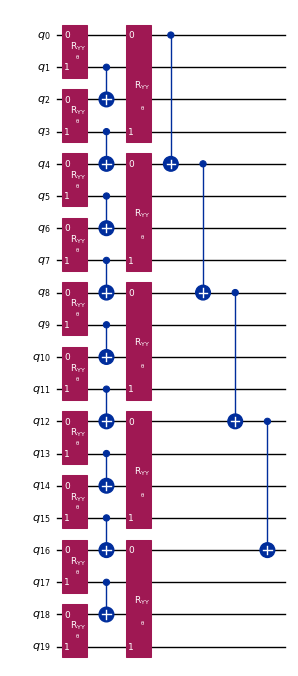

In [13]:
θ = Parameter("θ")
ansatz = QuantumCircuit(20)
for i in range(0, 19, 2):
    ansatz.ryy(θ, i, i + 1)
for i in range(1, 18, 2):
    ansatz.cx(i, i + 1)
for i in range(0, 18, 4):
    if i + 3 < 20:
        ansatz.ryy(θ, i, i + 3)
for i in range(0, 16, 4):
    ansatz.cx(i, i + 4)
parameters = [θ]
initial_point = np.array([0.1])
ansatz.draw(output="mpl", scale=0.5)

## 4. Results

To evaluate the performance of the VarQITE algorithm, the ground state projection of a Pauli-Z Hamiltonian on a 20-qubit system over 15 time steps with a small timestep of $\delta t$ was simulated. The algorithm was tested using a noiseless simulation using Qiskit's `StatevectorEstimator` and a hardware compatible execution using Fire Opal’s `iterate_expectation`. The `iterate_expectation` function allows observables to be evaluated on real quantum devices by automatically handling circuit serialization, parameter binding, and expectation value retrieval. This enables VarQITE to be deployed directly on supported backends without modifying the core algorithm.

In [ ]:
H = SparsePauliOp.from_list([("I" * 16 + "Z" * 4, 1.0)])
estimator = StatevectorEstimator()
theta_final_sim, energy_traj_sim = simple_varqite(
    ansatz=ansatz,
    parameters=parameters,
    hamiltonian=H,
    estimator=estimator,
    initial_point=initial_point,
    time_step=0.000005,
    steps=15,
    sim=True,
)

In [15]:
print("Final θ:", theta_final_sim)
print("Energies:", energy_traj_sim)

Final θ: [3.12975369]
Energies: [0.9950041652780273, 0.9887959374102139, 0.9749398100744986, 0.9442803385381537, 0.8777301376650831, 0.7392295941107241, 0.47570016723203157, 0.056658393136897606, -0.42745566551073527, -0.7789198932540332, -0.9341896733921105, -0.9826176498912486, -0.9955797832673395, -0.9988873875471794, -0.999720674230455]


In [ ]:
theta_final_real, energy_traj_real = simple_varqite(
    ansatz=ansatz,
    parameters=parameters,
    hamiltonian=H,
    estimator=estimator,
    initial_point=initial_point,
    time_step=0.000005,
    steps=15,
    sim=False,
)

In [17]:
# Stop iterating after all circuits are sent
fo.stop_iterate(credentials, backend_name)

In [18]:
print("Final θ:", theta_final_real)
print("Energies:", energy_traj_real)

Final θ: [3.12975369]
Energies: [1.0, 0.908203125, 0.861328125, 0.888671875, 0.77734375, 0.626953125, 0.3828125, 0.03125, -0.3515625, -0.697265625, -0.841796875, -0.923828125, -0.896484375, -0.8984375, -0.90234375]


In [13]:
def make_expectations_plot(exp_z, sim_z, name, step):
    depth_ticks = [0, 2, 4, 6, 8, 10, 12, 14]
    depths = list(range(step + 1))
    exp_z_error = np.abs(np.array(exp_z) - np.array(sim_z))

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
    top = np.max(sim_z[0:step])
    bottom = np.min(sim_z[0:step])
    top = 1.05
    bottom = -1.05
    plt.title("Imaginary-Time Energy Convergence")
    ax.plot(depths[0:step], sim_z[0:step], color="grey", label="Noiseless simulation")
    plt.axhline(-1, color="gray", linestyle="--", label="Ground state")
    if name == "qctrl":
        ax.errorbar(
            depths[0:step],
            exp_z[0:step],
            yerr=exp_z_error[0:step],
            fmt="o",
            markersize=7,
            label="Fire Opal",
            alpha=0.7,
            capsize=4,
            capthick=1,
        )
    elif name == "estimator":
        ax.errorbar(
            depths[0:step],
            exp_z[0:step],
            yerr=exp_z_error[0:step],
            fmt="o",
            markersize=7,
            color="black",
            label="Default QiskitRuntime",
            alpha=0.7,
            capsize=4,
            capthick=1,
        )
    ax.set_ylabel(r"$\langle Z \rangle$")
    ax.set_xticks(depth_ticks)
    ax.set_xlabel("Iteration")
    ax.legend()
    ax.set_ylim(bottom, top)
    ax.legend(prop={"size": 8})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

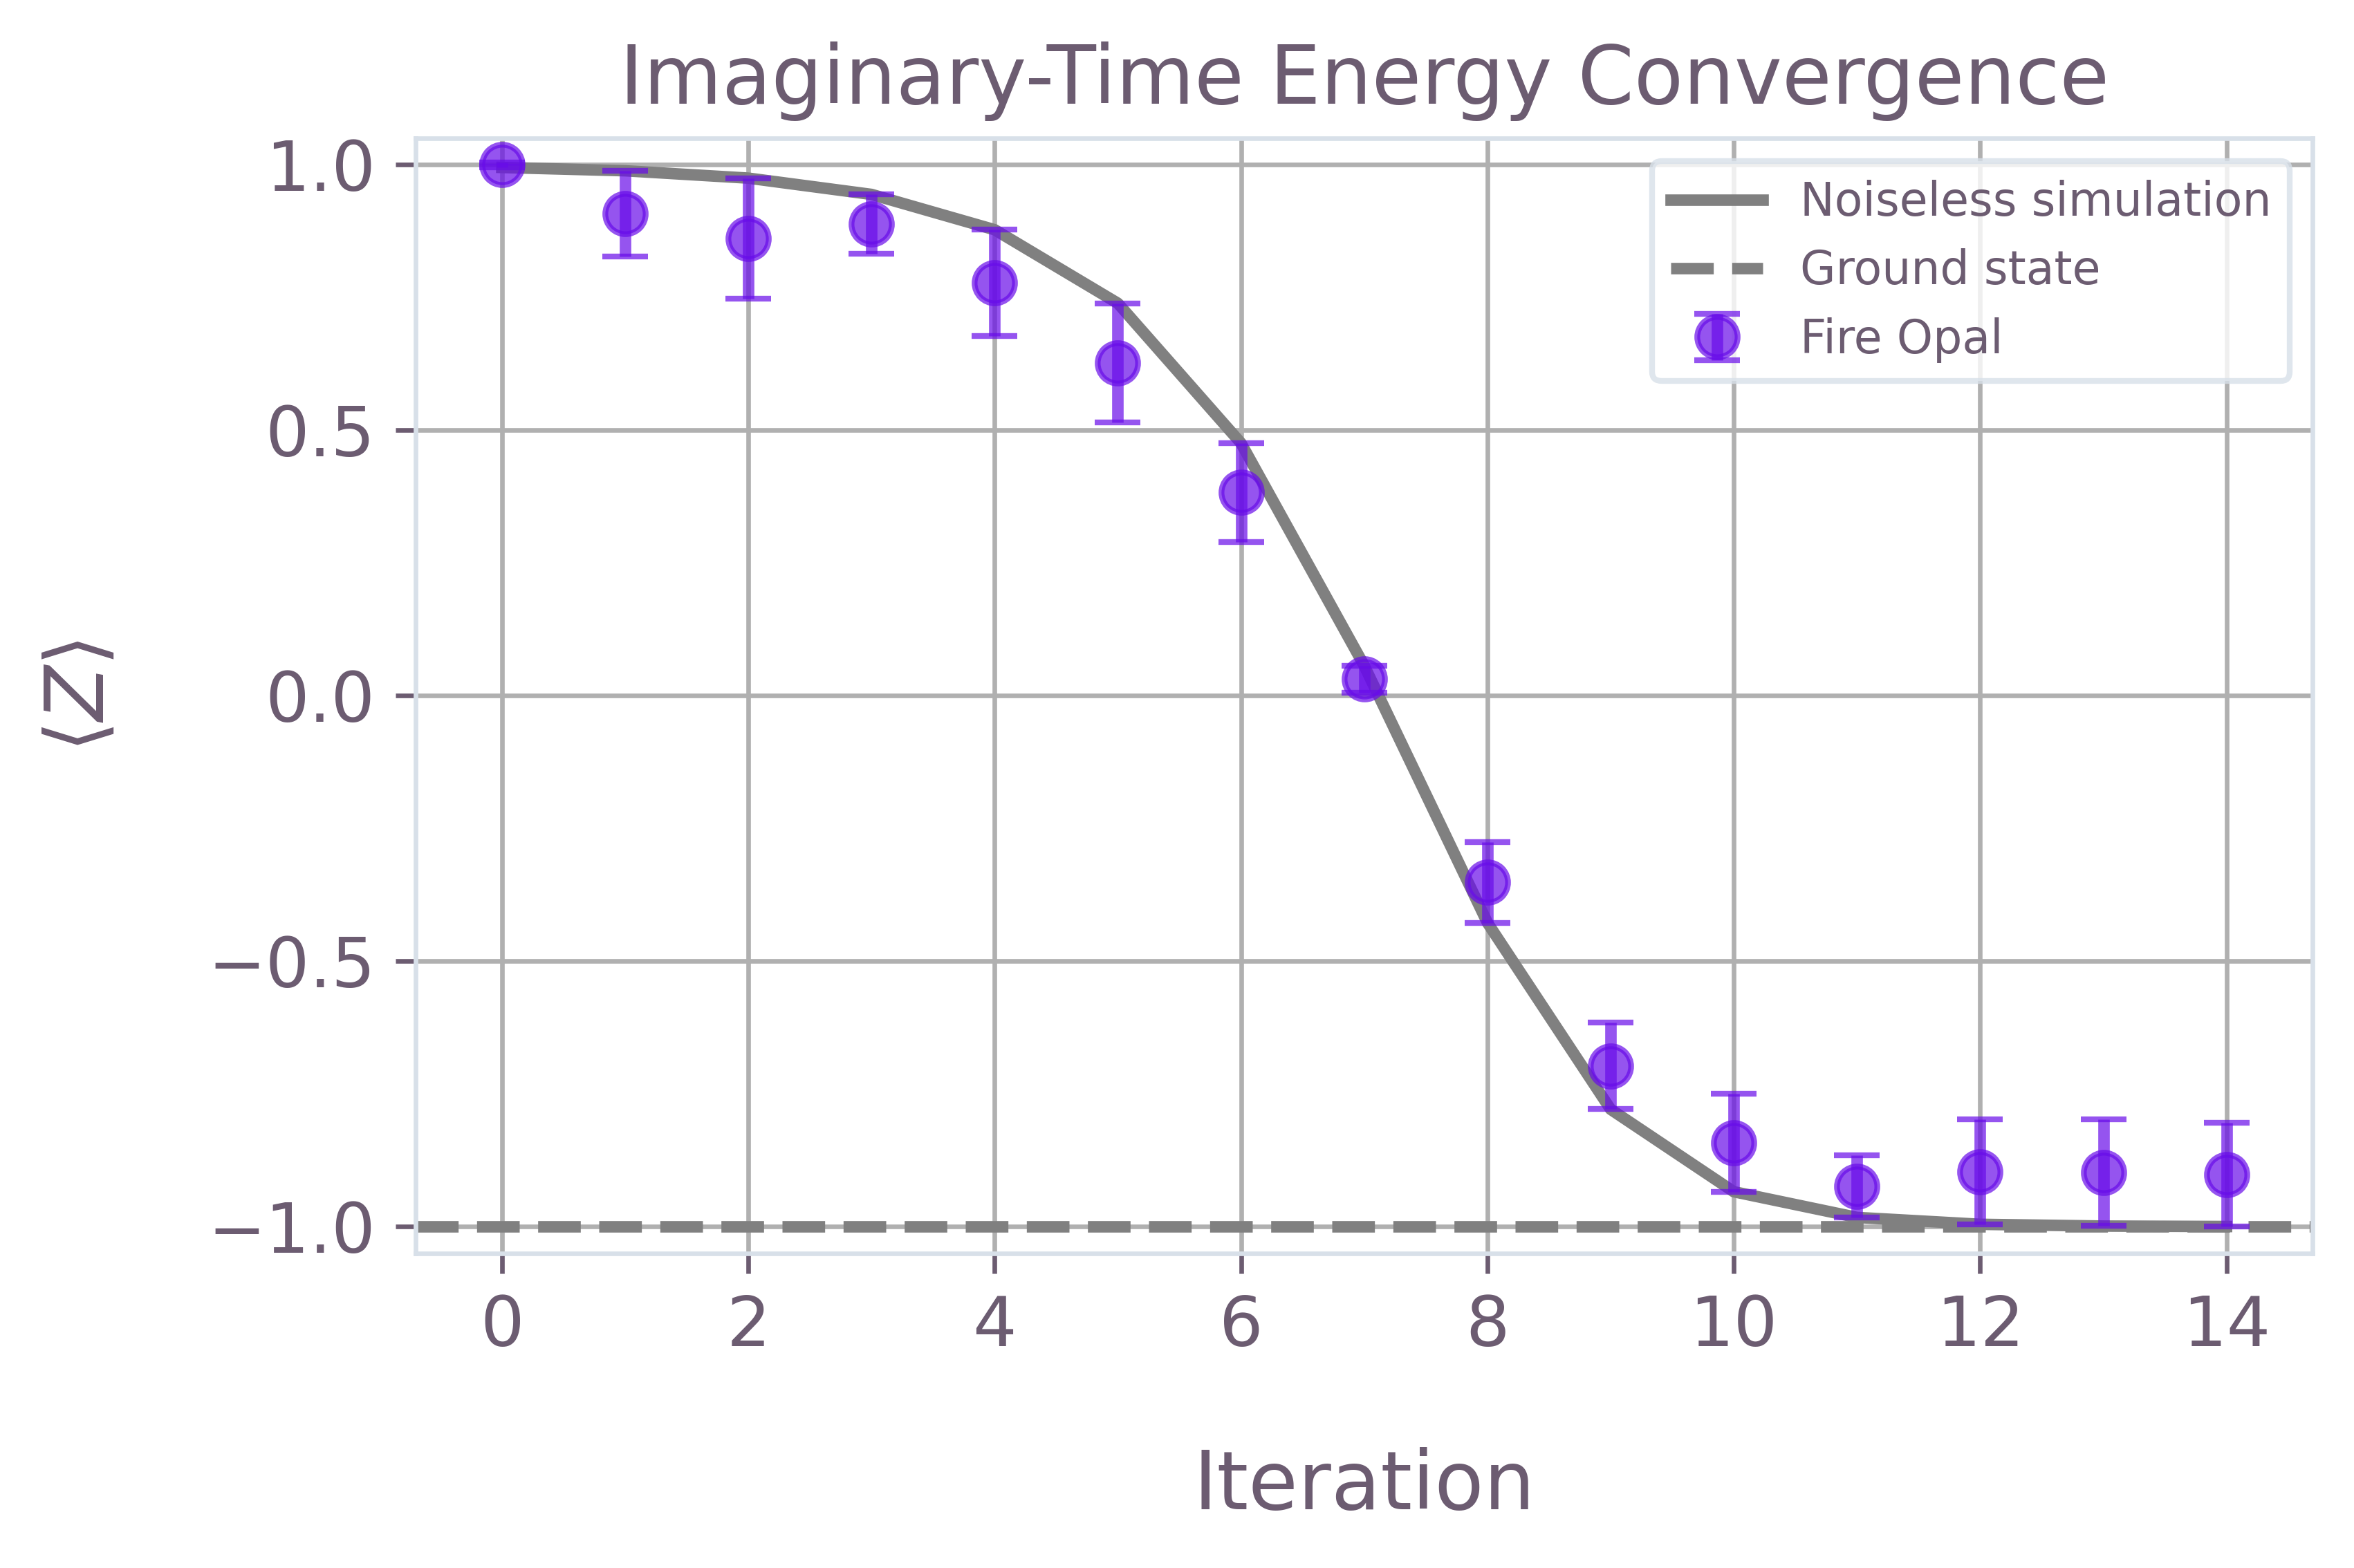

In [15]:
make_expectations_plot(energy_traj_real, energy_traj_sim, "qctrl", 15)

This application note demonstrates how Variational Quantum Imaginary Time Evolution (VarQITE) can be effectively implemented. By combining classical numerical methods with quantum state preparation, the algorithm enables ground state approximation. The integration of Fire Opal’s `iterate_expectation` provides a pathway to deploy this workflow on real quantum hardware. The observed convergence in both noiseless simulation and quantum hardware runs validates the accuracy of the finite-difference approach and the practicality of running variational algorithms on real quantum hardware via Fire Opal's `iterate_expectation`. 

In [27]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.12.9  |
| matplotlib            | 3.10.1  |
| networkx              | 2.8.8   |
| numpy                 | 1.26.4  |
| qiskit                | 1.4.2   |
| sympy                 | 1.13.3  |
| fire-opal             | 8.4.1   |
| qctrl-visualizer      | 8.0.2   |
| qctrl-workflow-client | 5.5.0   |
